In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,f1_score
import re
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statistics import mean


In [147]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import copy

### modAL 
from modal.models import ActiveLearner, Committee 
from modal.density import information_density
from modal.disagreement import max_disagreement_sampling, vote_entropy_sampling
from modal.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling, classifier_entropy, classifier_margin, classifier_uncertainty

### sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


### Suppresses Warning
import warnings
warnings.filterwarnings('ignore')

In [148]:
MY_PC = '.'
MY_DRIVE = '/content/drive/MyDrive/KFUPM/ICS485 Machine Learning/machine-learning'


working_on = MY_PC

# Reading the data

In [149]:
train_data = pd.read_csv(working_on + "/preprocessed_data/train_data.csv")
val_data = pd.read_csv(working_on + "/preprocessed_data/val_data.csv")
test_data = pd.read_csv(working_on + "/preprocessed_data/test_data.csv")

### Some info of the labeled data

In [150]:
train_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X13_ FC11,X13_ FC13,X13_ FC14,X14_ CA23,X14_ CA50,X14_ CA59,Y
0,-1.520449,-1.428585,1.530877,-1.162058,-0.836349,-0.535183,-1.042610,-2.433676,-0.612921,-0.707368,0.0,0.0,1.0,0.0,0.0,0.0,Mercedes
1,0.019717,-0.578489,1.649464,-0.522458,-0.204228,-0.694313,1.210780,-1.719345,-2.155114,-0.453929,0.0,1.0,0.0,0.0,0.0,0.0,BMW
2,-1.149807,0.019739,0.226418,-0.658669,-0.263490,-0.870256,1.034734,0.185537,-0.753121,-0.819252,0.0,0.0,1.0,0.0,0.0,0.0,Honda
3,-1.708274,-0.415010,1.530877,-0.984392,-0.540042,-1.025183,1.316407,-1.147880,-1.944815,-0.890957,0.0,0.0,1.0,0.0,0.0,0.0,Honda
4,-1.034608,-0.534895,1.175115,0.667908,1.711888,-0.910489,1.210780,-1.100258,-1.734516,-0.234488,0.0,0.0,1.0,1.0,0.0,0.0,Mercedes


,Column,Non-Null Count,Dtype,Unique Values
Y,Y,6714,object,6
X1,X1,6714,float64,1393
X2,X2,6714,float64,2763
X3,X3,6714,float64,48
X4,X4,6714,float64,657
X5,X5,6714,float64,306
X6,X6,6714,float64,3077
X7,X7,6714,float64,167
X8,X8,6714,float64,131
X9,X9,6714,float64,243


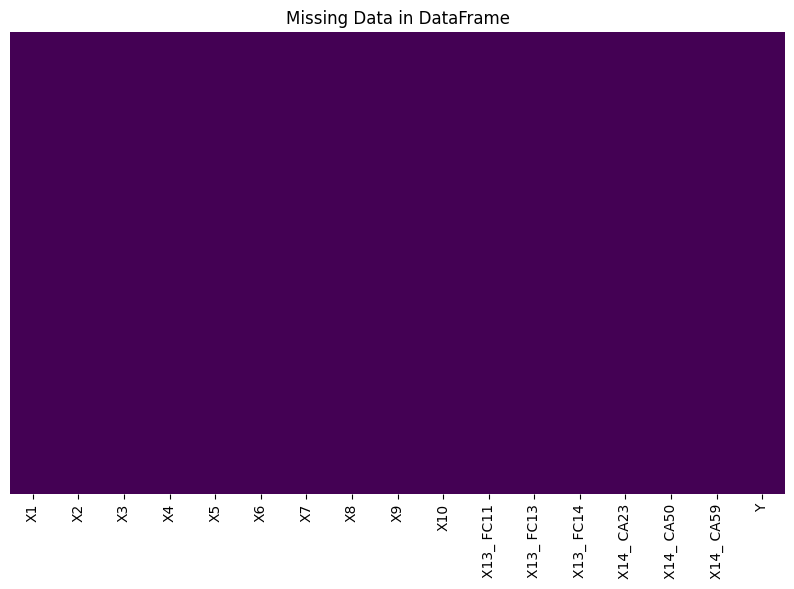

In [151]:
def display_dataframe_summary(dataframe, sort_by='Column'):

    summary = pd.DataFrame({
        'Column': dataframe.columns,
        'Non-Null Count': dataframe.notnull().sum(),
        'Dtype': dataframe.dtypes,
        'Unique Values': dataframe.nunique()
    })

    # Extracting numerical part from column names for sorting
    summary['Sort Key'] = summary['Column'].apply(lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)

    # Sorting the summary DataFrame
    if sort_by == 'Column':
        summary = summary.sort_values(by='Sort Key', ascending=True)
    else:
        summary = summary.sort_values(by=sort_by, ascending=True)

    summary = summary.drop('Sort Key', axis=1)  # Remove the auxiliary sort key column

    # Display the summary
    display(summary)

    # Plotting missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(dataframe.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Data in DataFrame')
    plt.show()

# Call the function with your DataFrame
display_dataframe_summary(train_data, sort_by='Column')


In [152]:
classes = train_data["Y"].unique()
number_of_classes = train_data["Y"].nunique()
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

print(f"The classes is: {classes}")
print(f"Number of classes: {number_of_classes}")
print(categorical_cols)

The classes is: ['Mercedes' 'BMW' 'Honda' 'Toyota' 'GMC' 'Ford']
Number of classes: 6
Index(['Y'], dtype='object')


In [153]:
# X_train = train_data.drop('Y', axis=1).to_numpy()
# y_train = pd.get_dummies(train_data['Y']).to_numpy()

# X_val = val_data.drop('Y', axis=1).to_numpy()
# y_val = pd.get_dummies(val_data['Y']).to_numpy()

# X_test = test_data.drop('Y', axis=1).to_numpy()
# y_test = pd.get_dummies(test_data['Y']).to_numpy()


X_train = train_data.drop('Y', axis=1).to_numpy()
y_train = train_data['Y']
y_train = LabelEncoder().fit_transform(y_train)


X_val = val_data.drop('Y', axis=1).to_numpy()
y_val = pd.get_dummies(val_data['Y']).to_numpy()
# y_train = LabelEncoder().fit_transform(y_train)

X_test = test_data.drop('Y', axis=1).to_numpy()
y_test = test_data['Y']
y_train = LabelEncoder().fit_transform(y_train)



In [154]:
# training set contains one instance from each of 10 labels
X_training, y_training = [], []
for i in range(6):
    
    # return index of first element in list with label i
    unique_label_idx = list(y_train).index(i)
    
    # get the feature array corresponding to this element
    xx = X_train[unique_label_idx]
    
    # add instance to training data
    X_training.append(xx)
    y_training.append(i)
    
    # remove instance from original data
    X_train, y_train  = np.delete(X_train, unique_label_idx, axis=0), np.delete(y_train, unique_label_idx, axis=0)

    
# split remaining data into pool and test subsets
X_pool, X_test, y_pool, y_test = train_test_split(X_train,y_train,test_size=0.5,random_state=777)

# convert lists to numpy arrays
X_training = np.asarray(X_training)
y_training = np.asarray(y_training)

# Building Model

In [155]:
def random_query(classifier, X):
    
    n_samples = len(X)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X[query_idx]

In [156]:
def get_next_sample(learner, X, y):

    
    # call the query strategy defined in the learner to obtain a new sample
    query_idx, query_sample = learner.query(X)
    
    # modify indexing to interpret as collection of one element with 26 features
    query_sample_reshaped = query_sample.reshape(1,-1)
   
    # obtain the query label
    query_label = y[query_idx]

    # modify indexing to interpret as 1D array of one element
    query_label_reshaped = query_label.reshape(1,)
    
    return query_sample_reshaped, query_label_reshaped, query_idx

In [157]:
def run_active_learner(learner, X_pool, y_pool, X_test, y_test, num_queries):
   
    history = [] # score history
    
    # score model before active learning starts
    history.append(learner.score(X_test,y_test))

    # perform active learning
    for idx in range(num_queries):

        # get sample
        X_sample, y_sample, query_idx = get_next_sample(learner, X_pool, y_pool)

        # use new sample to update the model
        learner.teach(X_sample, y_sample)

        # score against test data
        current_score = learner.score(X_test,y_test)

        # save score
        history.append(current_score)
        
        # remove labeled instance from pool
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx)
        
    return history

In [158]:
# Split the data into a pool (unlabeled) and an initial labeled set
X_initial, X_pool, y_initial, y_pool = train_test_split(
    X_train, y_train, train_size=100, stratify=y_train
)

# copy data for use with this section
X_pool_rand_lr = copy.deepcopy(X_pool)
y_pool_rand_lr = copy.deepcopy(y_pool)



# define learner, including training data as starting point
learner = ActiveLearner(
    estimator=LogisticRegression(),
    query_strategy=random_query,
    X_training=X_initial, 
    y_training=y_initial
)


# run active learner and obtain score history
history_rand_lr = run_active_learner(learner, X_pool_rand_lr, y_pool_rand_lr, X_test, y_test, 100)

In [159]:
history_rand_lr

[0.7426952892069171,
 0.7423971377459749,
 0.751937984496124,
 0.753726893261777,
 0.753726893261777,
 0.7552176505664878,
 0.7558139534883721,
 0.7552176505664878,
 0.7540250447227191,
 0.7510435301132976,
 0.7510435301132976,
 0.7492546213476446,
 0.7507453786523554,
 0.7510435301132976,
 0.7528324388789505,
 0.7546213476446034,
 0.753726893261777,
 0.7540250447227191,
 0.7525342874180083,
 0.7522361359570662,
 0.7513416815742398,
 0.7531305903398927,
 0.7596899224806202,
 0.7596899224806202,
 0.7590936195587359,
 0.7590936195587359,
 0.7590936195587359,
 0.7587954680977936,
 0.7587954680977936,
 0.7656529516994633,
 0.7653548002385212,
 0.7641621943947525,
 0.7644603458556947,
 0.7635658914728682,
 0.7668455575432319,
 0.7668455575432319,
 0.7665474060822898,
 0.7665474060822898,
 0.7671437090041742,
 0.7671437090041742,
 0.7671437090041742,
 0.7665474060822898,
 0.7674418604651163,
 0.7674418604651163,
 0.7674418604651163,
 0.7683363148479427,
 0.7686344663088849,
 0.76893261776982

In [160]:
# final accuracy
print('Final accuracy of Logistic Regression with random sampling: \t{:.3f}'.format(history_rand_lr[-1]))

Final accuracy of Logistic Regression with random sampling: 	0.771


In [ ]:


# Split the data into a pool (unlabeled) and an initial labeled set
X_initial, X_pool, y_initial, y_pool = train_test_split(
    X_train, y_train, train_size=100, stratify=y_train
)

model = xgb.XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.1, random_state=777)

# Train the initial model on the labeled samples
model.fit(X_initial, y_initial)

# Number of samples to query in each iteration
query_size = 10

# Calculate initial f1 scores
training_f1_initial = f1_score(y_initial, model.predict(X_initial), average='macro')
validation_f1_initial = f1_score(y_val, model.predict(X_val), average='macro')  # Assuming y_val and X_val are your validation data

print("Original model performance: ")
print(f"Training f1 score: {training_f1_initial:.2f}")
print(f"Validation f1 score: {validation_f1_initial:.2f}")
print("-" * 100)

# Number of iterations
# num_iterations = (len(X_pool) - len(X_initial)) // query_size
num_iterations = 5


for i in range(num_iterations):
    # Calculate predicted probabilities for each class
    probas = model.predict_proba(X_pool)

    # Calculate the least confident score for each sample
    least_confident_scores = 1 - np.max(probas, axis=1)

    # Select the top 'query_size' samples with the lowest confidence
    query_indices = np.argsort(least_confident_scores)[:query_size]

    # Label the selected samples and remove them from the pool
    X_query = X_pool[query_indices]
    y_query = model.predict(X_query)

    X_pool = np.delete(X_pool, query_indices, axis=0)
    y_pool = np.delete(y_pool, query_indices)

    # Add the newly labeled samples to the initial set
    X_initial = np.vstack([X_initial, X_query])
    y_initial = np.concatenate([y_initial, y_query])

    # Retrain the model on the updated labeled set
    model.fit(X_initial, y_initial)

    # Calculate f1 scores
    training_f1 = f1_score(y_initial, model.predict(X_initial), average='macro')
    validation_f1 = f1_score(y_val, model.predict(X_val), average='macro')

    print(f"Iteration {i+1} performance:")
    print(f"Training f1 score: {training_f1:.2f}")
    print(f"Validation f1 score: {validation_f1:.2f}")
    print("-" * 100)



# Showing model performance on testing set

In [ ]:
def evaluate_model(model,X_test,y_test):
    

    y_pred = model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Final accuracy on the test set: {test_accuracy:.4f}")

    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)
    
    print("Confusion Matrix:")
    cm_display.plot()
    plt.show()
    
    report = classification_report(y_test, y_pred, target_names=classes)
    print(report)

In [ ]:
print('Active Learning RF(Entropy) Model Performance on Testing Set:')
evaluate_model(model,X_test,y_test)